# Importing Libraries

In [1]:
import pathlib
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Loading Dataset

In [2]:
img_size = (244, 244)
batch_size = 8
train_dir= 'train'
val_dir= 'validation'
test_dir= 'test'

# Data Preprocessing and Augmentation

In [3]:
import tensorflow as tf
# Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=img_size,
  batch_size=batch_size,
  #color_mode='grayscale',
  label_mode = 'categorical')

# Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=img_size,
  batch_size=batch_size,
  #color_mode='grayscale',
  label_mode = 'categorical')

# Test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=img_size,
  batch_size=batch_size,
  #color_mode='grayscale',
  label_mode = 'categorical')

Found 5620 files belonging to 8 classes.
Found 1730 files belonging to 8 classes.
Found 680 files belonging to 8 classes.


In [4]:
def norm_data(ds):
    prepr_layer = tf.keras.layers.Rescaling(1./255)
    norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

    return norm_ds

In [5]:
def augment_data1(ds, crop_size):
    # CenterCrop
    layer1 = tf.keras.layers.CenterCrop(crop_size, crop_size)
    aug_ds = ds.map(lambda x, y: (layer1(x), y))

    # RandomRotation
    layer2 = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05))
    aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

    # RandomZoom
    layer3 = tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1, -0.01))
    aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))

    return aug_ds

In [6]:
img_height = 244
train_ds_aug = augment_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)
val_ds_aug = augment_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

test_ds_aug = augment_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

# Ensemble Architecture - Meta Model

In [7]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Define checkpoint path

In [8]:
checkpoint_path = "Ensemble_Checkpoint/Ensemble_CNN_DenseNet.keras"

# Remove the existing checkpoint file if it exists
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

### EarlyStopping callbacks

In [9]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True, verbose=1)

### Ensembling Features

In [10]:
# Load pre-trained models
model_CNN = load_model('CNN.h5')
model_dnsnt201 = load_model('densenet201.h5')

# Remove top layers
model_CNN_feature = tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.layers[-2].output)
model_dnsnt201_feature = tf.keras.Model(inputs=model_dnsnt201.input, outputs=model_dnsnt201.layers[-2].output)

# Input layer
num_classes = 8
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Extract features
CNN_features = model_CNN_feature(inputs)
dnsnt201_features = model_dnsnt201_feature(inputs)

# Concatenate features
combined_features = Concatenate()([CNN_features, dnsnt201_features])

### Meta Model Architecture

In [11]:
#  Architecture
x = Dense(512, activation='relu')(combined_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

ensemble_model = Model(inputs=inputs, outputs=outputs)

# Compilation
opt1 = optimizers.Adam(learning_rate=2e-5)
ensemble_model.compile(optimizer=opt1, loss="categorical_crossentropy", metrics=['accuracy'])

# Model Fit
history_ensemble = ensemble_model.fit(
    train_ds_norm,
    epochs=50,
    validation_data=val_ds_norm,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
703/703 [==============================] - 150s 180ms/step - loss: 2.0324 - accuracy: 0.3404 - val_loss: 0.6383 - val_accuracy: 0.8000
Epoch 2/50
703/703 [==============================] - 104s 148ms/step - loss: 1.1533 - accuracy: 0.5731 - val_loss: 0.4144 - val_accuracy: 0.8838
Epoch 3/50
703/703 [==============================] - 104s 148ms/step - loss: 0.8656 - accuracy: 0.6836 - val_loss: 0.2974 - val_accuracy: 0.9156
Epoch 4/50
703/703 [==============================] - 104s 148ms/step - loss: 0.5879 - accuracy: 0.8018 - val_loss: 0.3148 - val_accuracy: 0.9266
Epoch 5/50
703/703 [==============================] - 103s 147ms/step - loss: 0.4403 - accuracy: 0.8509 - val_loss: 0.4823 - val_accuracy: 0.9191
Epoch 6/50
703/703 [==============================] - 104s 148ms/step - loss: 0.3331 - accuracy: 0.8970 - val_loss: 0.4116 - val_accuracy: 0.9318
Epoch 7/50
703/703 [==============================] - 104s 148ms/step - loss: 0.2647 - accuracy: 0.9222 - val_loss: 0.4595 -

# Model Evaluation

# Loss and Accuracy Curve

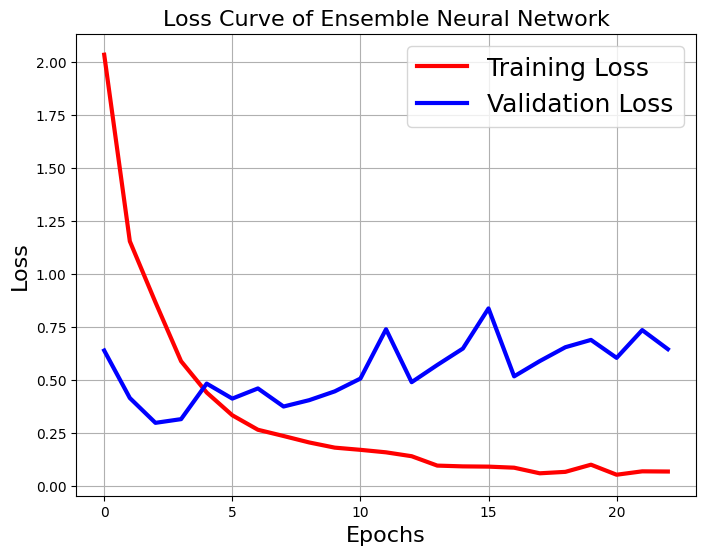

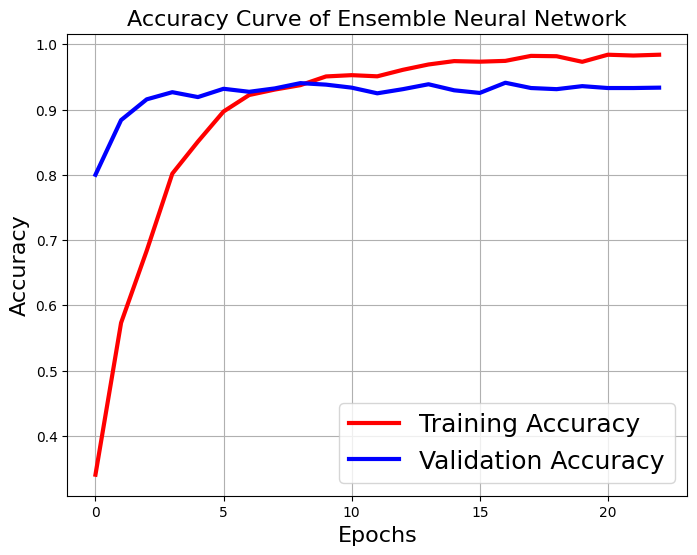

In [12]:
# Define class names
class_names = train_ds.class_names

# Plotting the Loss and Accuracy Curves
plt.figure(figsize=[8,6])

# Plot Loss
plt.plot(history_ensemble.history['loss'], 'r', linewidth=3.0)
plt.plot(history_ensemble.history['val_loss'], 'b', linewidth=3.0)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=18)
plt.title('Loss Curve of Ensemble Neural Network', fontsize=16)
plt.grid(True)
plt.show()

plt.figure(figsize=[8,6])

# Plot Accuracy
plt.plot(history_ensemble.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history_ensemble.history['val_accuracy'], 'b', linewidth=3.0)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.title('Accuracy Curve of Ensemble Neural Network', fontsize=16)
plt.grid(True)
plt.show()

# Classification Report

In [13]:
from sklearn.metrics import classification_report

# Evaluate the model
loss, accuracy = ensemble_model.evaluate(val_ds_norm)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Generate predictions
y_pred_prob = ensemble_model.predict(val_ds_norm)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Get true labels
y_true = []
for images, labels in val_ds_norm:
    y_true.extend(tf.argmax(labels, axis=1).numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

217/217 [==============================] - 8s 37ms/step - loss: 0.2974 - accuracy: 0.9156
Validation Loss: 0.2973611652851105
Validation Accuracy: 0.9156069159507751
217/217 [==============================] - 10s 35ms/step
Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.91      0.92      0.92       215
dyed-resection-margins       0.98      0.91      0.94       215
           esophagitis       0.88      0.79      0.83       215
          normal-cecum       0.99      0.99      0.99       215
        normal-pylorus       0.91      0.99      0.95       215
         normal-z-line       0.83      0.87      0.85       215
                polyps       0.91      0.89      0.90       215
    ulcerative-colitis       0.93      0.97      0.95       225

              accuracy                           0.92      1730
             macro avg       0.92      0.92      0.91      1730
          weighted avg       0.92      0.92     

# Calculate accuracy, precision, recall, F1-score

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Calculate accuracy, precision, recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.915606936416185
Precision: 0.9160607307353376
Recall: 0.915606936416185
F1-score: 0.9150474259308592


# Confusion matrix

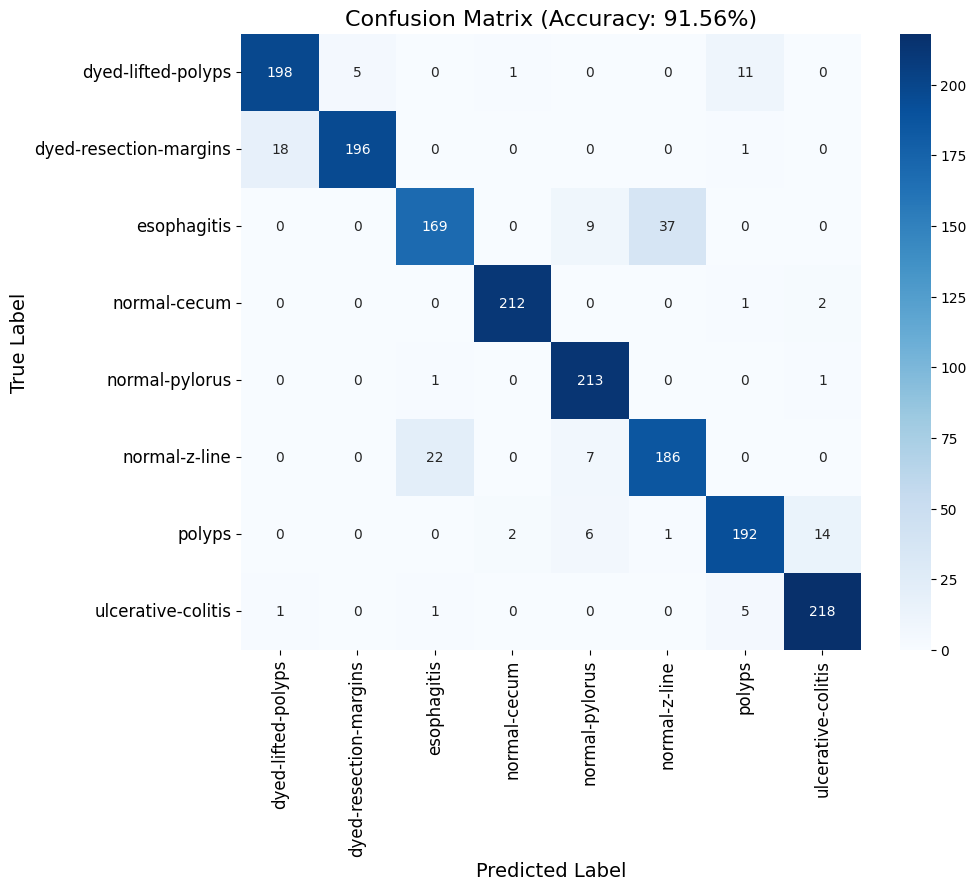

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Compute confusion matrix and accuracy
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred) * 100

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.show()